# Импорт модулей

In [195]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

import torch

# Превращаю видео в картинки, чтобы было удобнее

Беру не каждый кадр, чтобы не перегружать выборку и ГПУху

In [22]:
data = pd.read_csv('data.csv')
print('data shape:', data.shape)

data shape: (463, 4)


In [24]:
data[data.point == 'kil']

,path,point,x,y
0,data/19_0.png,kil,769.33,356.96
11,data/18_900.png,kil,697.56,300.71
12,data/18_750.png,kil,470.52,303.12
23,data/18_600.png,kil,509.34,326.52
27,data/18_450.png,kil,668.72,328.44
...,...,...,...,...
431,data/0_150.png,kil,597.03,336.08
441,data/0_1350.png,kil,749.30,319.10
443,data/0_1200.png,kil,739.20,318.40
451,data/0_1050.png,kil,717.08,316.40


In [161]:
paths = []
dists = []
tangs = []
krens = []

j = 0

for path, d, t, k in tqdm(zip(data.path, data.dist, data.tang, data.kren)):
    
    cap = cv2.VideoCapture(path)
    
    i = 0
    
    while(cap.isOpened()):
        
        ret, frame = cap.read()
        
        if ret == True:        
            if i%30 == 0:
    
                cv2.imwrite('data_boxes/data/{}_{}.png'.format(j, i), cv2.resize(frame, (1280, 720)))
                paths.append('data_boxes/data/{}_{}.png'.format(j, i))
                dists.append(d)
                tangs.append(t)
                krens.append(k)
        
        else:
            break
            
        i += 1
    
    j += 1
    
    cap.release()
    
data_processed = pd.DataFrame()

data_processed['path'] = paths 
data_processed['dist'] = dists
data_processed['tang'] = tangs
data_processed['kren'] = krens

24it [07:02, 17.58s/it]


In [166]:
data_processed

,path,dist,tang,kren
0,data_boxes/data/0_0.png,3195.0,-14.0,3.0
1,data_boxes/data/0_30.png,3195.0,-14.0,3.0
2,data_boxes/data/0_60.png,3195.0,-14.0,3.0
3,data_boxes/data/0_90.png,3195.0,-14.0,3.0
4,data_boxes/data/0_120.png,3195.0,-14.0,3.0
...,...,...,...,...
1328,data_boxes/data/23_2790.png,2442.0,0.0,0.0
1329,data_boxes/data/23_2820.png,2442.0,0.0,0.0
1330,data_boxes/data/23_2850.png,2442.0,0.0,0.0
1331,data_boxes/data/23_2880.png,2442.0,0.0,0.0


In [163]:
data_processed.to_csv('data_boxes/data_boxes.csv', index=False)

# Добавляю разметку боксов с самолетами через YOLOV5

Ёло уже предобучена детектить самолеты, так что все круто

In [9]:
data_boxes = pd.read_csv('data_boxes/data_boxes.csv')

In [13]:
detection_model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)  # or yolov5m, yolov5l, yolov5x, custom

def get_detection_bbox(path_to_image):
    
    results = detection_model(path_to_image).pandas().xyxy[0]
    results = results[results.name == 'airplane']
    
    try:
        x1 = int(results.values[0][0])
        y1 = int(results.values[0][1])
        x2 = int(results.values[0][2])
        y2 = int(results.values[0][3])
        return x1, y1, x2, y2
    except:
        return np.nan, np.nan, np.nan, np.nan, 

Using cache found in /Users/neironeiro/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-11-19 torch 1.9.0 CPU

Fusing layers... 
Model Summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


In [14]:
coords = []

for path in tqdm(data_boxes.path):
    
    x1, y1, x2, y2 = get_detection_bbox(path)
    coords.append([x1, y1, x2, y2])

data_boxes[['x1', 'y1', 'x2', 'y2']] = coords

100%|██████████| 1333/1333 [03:55<00:00,  5.67it/s]


In [17]:
data_boxes = data_boxes[data_boxes.x1.notnull()]
data_boxes[['x1', 'y1', 'x2', 'y2']] = data_boxes[['x1', 'y1', 'x2', 'y2']].astype(int)

/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [19]:
data_boxes.to_csv('data_boxes/data_boxes.csv', index=False)

# Подгружаю итоговый вариант данных

In [142]:
train = pd.read_csv('data_boxes/data_boxes.csv')

In [143]:
x1 = int(train.x1.iloc[0])
y1 = int(train.y1.iloc[0])
x2 = int(train.x2.iloc[0])
y2 = int(train.y2.iloc[0])

In [144]:
img_show = cv2.cvtColor(cv2.imread(train.path.iloc[0]), cv2.COLOR_BGR2RGB)

In [145]:
img_show = img_show[int(y1-y1*0.05):int(y2+y2*0.05), int(x1-x1*0.05):int(x2+x2*0.05), :]

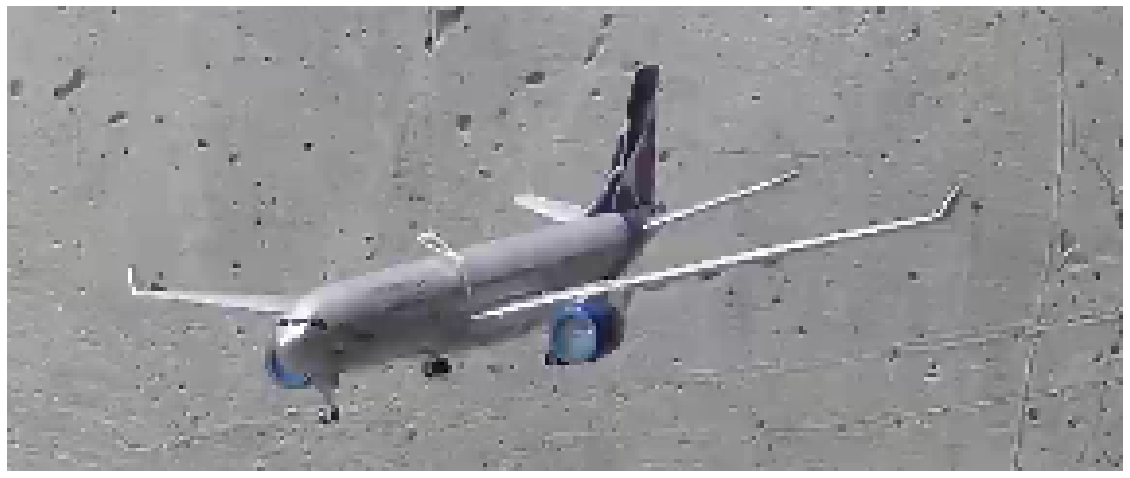

In [146]:
plt.figure(figsize=(20, 20))
plt.imshow(img_show)
plt.axis('off')
plt.savefig('img_show.png')

# Эвристики

In [147]:
# Считать все буду по этой формуле

# w - истинная ширина бокса (с неповернутым самолетом), буду брать как максимальную ширину бокса
# bw - ширина бокса


# cos(A) = bw/w
# A = arccos(bw/w) - угол курса, однако стоит учитывать, что угол у меня от 0 до 90, так как я не учитываю ориентацию самолета
#                                данный момент решается ручной разметкой (сейчас на нее просто нет времени)

In [148]:
# AIRBUS A330
# 60m wings
# 62m tail

# Можно сделать погрешность на то, крылья это или тело, и считать ширину предсказанного бокса
# По этой же условности можно считать азимут и угол места, беря за центр самолета – центр бокса

In [149]:
# эвристика для курса
train['bw'] = train.x2 - train.x1
train['course'] = 57.2958 * np.arccos(train.bw / train.groupby('dist').bw.transform('max'))

In [150]:
# эвристика для азимута
# tg(azim) = (x_c - 640) / dist
# azim = 57.2958 * arctg((x_c - 640) / dist)
train['x_c'] = train.x2 - ((train.x2 - train.x1) / 2)
train['azim'] = 57.2958 * np.arctan((train.x_c - 640) / train.dist)

In [151]:
# эвристика для угла места (аналогично с азимутом)
train['y_c'] = train.y2 - ((train.y2 - train.y1) / 2)
train['terr_angle'] = 57.2958 * np.arctan((train.y_c - 360) / train.dist)

In [152]:
train

,path,dist,tang,kren,x1,y1,x2,y2,bw,course,x_c,azim,y_c,terr_angle
0,data_boxes/data/0_0.png,3195.0,-14.0,3.0,544,298,764,383,220,30.373797,654.0,0.251060,340.5,-0.349688
1,data_boxes/data/0_30.png,3195.0,-14.0,3.0,540,296,763,385,223,29.012996,651.5,0.206228,340.5,-0.349688
2,data_boxes/data/0_60.png,3195.0,-14.0,3.0,527,300,762,386,235,22.843515,644.5,0.080698,343.0,-0.304857
3,data_boxes/data/0_90.png,3195.0,-14.0,3.0,515,302,750,385,235,22.843515,632.5,-0.134497,343.5,-0.295891
4,data_boxes/data/0_120.png,3195.0,-14.0,3.0,524,301,748,388,224,28.546294,636.0,-0.071732,344.5,-0.277959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,data_boxes/data/23_2790.png,2442.0,0.0,0.0,520,323,780,399,260,41.472007,650.0,0.234625,361.0,0.023463
1189,data_boxes/data/23_2820.png,2442.0,0.0,0.0,500,322,771,399,271,38.649639,635.5,-0.105582,360.5,0.011731
1190,data_boxes/data/23_2850.png,2442.0,0.0,0.0,499,323,768,400,269,39.175381,633.5,-0.152507,361.5,0.035194
1191,data_boxes/data/23_2880.png,2442.0,0.0,0.0,493,322,771,398,278,36.759691,632.0,-0.187701,360.0,0.000000


# Генератор для обучения нейронки для параметров

In [153]:
def augment_image(image):

    aug = A.Compose([
        
        A.OneOf([
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.5),
    
    ])

    augmented = aug(image=image)

    return augmented['image'] 

In [164]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=4,
                 input_shape=(300, 150, 3),
                 shuffle=True):
        
        self.data = df
        self.paths = df.path.unique()
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths):
    
        X_batch = []
        y_batch = []
        
        for path in paths:
            
            x1 = int(self.data[self.data.path == path].x1.iloc[0])
            y1 = int(self.data[self.data.path == path].y1.iloc[0])
            x2 = int(self.data[self.data.path == path].x2.iloc[0])
            y2 = int(self.data[self.data.path == path].y2.iloc[0])
            
            X = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            X = X[int(y1-y1*0.05):int(y2+y2*0.05), int(x1-x1*0.05):int(x2+x2*0.05), :]
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            
            if self.augment:
                X = augment_image(X)
            
            X_batch.append(X / 255.)
            
            y = np.zeros(3)
            
            y[0] = self.data[self.data.path == path]['tang'].iloc[0]
            y[0] = (y[0] - -14) / (14 - -14)
        
            y[1] = self.data[self.data.path == path]['kren'].iloc[0]
            y[1] = (y[1] - -2) / (3 - -2)
            
            y[2] = self.data[self.data.path == path]['course'].iloc[0]
            y[2] = (y[2] - 0) / (66 - 0)
            
            y_batch.append(y)
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

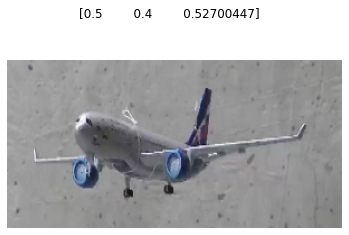

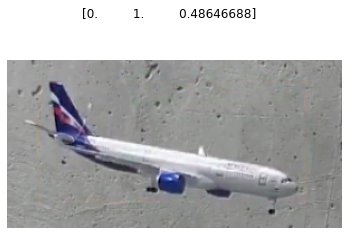

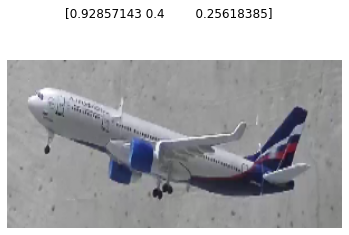

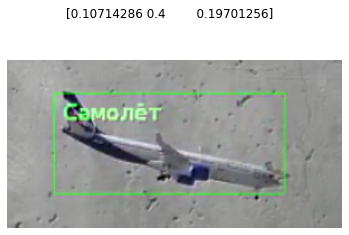

In [166]:
traingen = CustomDataGen(train)

for x, y in traingen:
    break

i = 0
for xx, yy in zip(x, y):
    plt.imshow(xx)
    plt.suptitle(yy)
    plt.axis('off')
    plt.show()
    i+=1

# Модель для параметров: тангаж, крен, курс

In [167]:
def create_model(input_shape=(150, 300, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, classes=1)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(3, activation='linear')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [168]:
K.clear_session()

model = create_model()

metrics = [
    'mae',
]

model.compile(optimizer=Adam(), loss='mse', metrics=metrics)

In [169]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 300, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 10, 1280)       4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 4,378,278
Trainable params: 4,336,255
Non-trainable params: 42,023
______________________________________________

In [170]:
train_df, val_df = train_test_split(train, test_size=0.15)

traingen = CustomDataGen(train_df)
valgen = CustomDataGen(val_df, augment=False)

In [171]:
checkpoint_path = 'models/params.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, 
                    save_best_only=True, save_weights_only=False)
]

In [172]:
model.compile(optimizer=Adam(), loss='mse', metrics=metrics)

In [179]:
results = model.fit(traingen, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
253/253 [==============================] - 57s 227ms/step - loss: 0.0210 - mae: 0.1114 - val_loss: 0.2503 - val_mae: 0.4070

Epoch 00001: val_loss improved from inf to 0.25034, saving model to models/params.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
253/253 [==============================] - 56s 222ms/step - loss: 0.0145 - mae: 0.0925 - val_loss: 0.2251 - val_mae: 0.3840

Epoch 00002: val_loss improved from 0.25034 to 0.22512, saving model to models/params.h5
Epoch 3/50
253/253 [==============================] - 57s 225ms/step - loss: 0.0104 - mae: 0.0780 - val_loss: 0.4204 - val_mae: 0.4583

Epoch 00003: val_loss did not improve from 0.22512
Epoch 4/50
253/253 [==============================] - 56s 222ms/step - loss: 0.0078 - mae: 0.0676 - val_loss: 44069.0586 - val_mae: 186.8921

Epoch 00004: val_loss did not improve from 0.22512
Epoch 5/50
253/253 [==============================] - 57s 223ms/step - loss: 0.0072 - mae: 0.0644 - val_loss: 0.1106 - val_mae: 0.2643

Epoch 00005: val_loss improved from 0.22512 to 0.11055, saving model to models/params.h5
Epoch 6/50
253/253 [==============================] - 55s 219ms/step - loss: 0.0064 - mae: 0.0594 - val_loss: 0.1952 - val_mae: 0.3573

Epoch 00006: val_loss did not impr

In [180]:
pred_tangs = []
pred_kren = []
pred_course = []

val_tangs = []
val_kren = []
val_course = []

for x, y in valgen:
    
    preds = model.predict(x)
    
    preds[:, 0] = 28 * preds[:, 0] - 14
    preds[:, 1] = 5 * preds[:, 1] - 2
    preds[:, 2] = 66 * preds[:, 2]
    
    y[:, 0] = 28 * y[:, 0] - 14
    y[:, 1] = 5 * y[:, 1] - 2
    y[:, 2] = 66 * y[:, 2]
    
    _ = [pred_tangs.append(x) for x in preds[:, 0]]
    _ = [pred_kren.append(x) for x in preds[:, 1]]
    _ = [pred_course.append(x) for x in preds[:, 2]]
    
    _ = [val_tangs.append(x) for x in y[:, 0]]
    _ = [val_kren.append(x) for x in y[:, 1]]
    _ = [val_course.append(x) for x in y[:, 2]]
    

In [204]:
train.course.describe()

count    1193.000000
mean       30.756312
std        10.535898
min         0.000000
25%        23.556473
50%        30.902325
75%        37.612480
max        65.718844
Name: course, dtype: float64

In [207]:
print('TANG MAE –', mean_absolute_error(val_tangs, pred_tangs))
# print('TANG MAPE –', mean_absolute_percentage_error(val_tangs, pred_tangs))

print('\nKREN MAE –', mean_absolute_error(val_kren, pred_kren))
# print('KREN MAPE –', mean_absolute_percentage_error(val_kren, pred_kren))

print('\nCOURSE MAE –', mean_absolute_error(val_course, pred_course))
# print('COURSE MAPE –', mean_absolute_percentage_error(val_course, pred_course))

TANG MAE – 0.4765819853002375

KREN MAE – 0.060769488188353454

COURSE MAE – 1.49191546357751


In [205]:
100 * 1.49 / 66

2.257575757575758

In [206]:
train

,path,dist,tang,kren,x1,y1,x2,y2,bw,course,x_c,azim,y_c,terr_angle
0,data_boxes/data/0_0.png,3195.0,-14.0,3.0,544,298,764,383,220,30.373797,654.0,0.251060,340.5,-0.349688
1,data_boxes/data/0_30.png,3195.0,-14.0,3.0,540,296,763,385,223,29.012996,651.5,0.206228,340.5,-0.349688
2,data_boxes/data/0_60.png,3195.0,-14.0,3.0,527,300,762,386,235,22.843515,644.5,0.080698,343.0,-0.304857
3,data_boxes/data/0_90.png,3195.0,-14.0,3.0,515,302,750,385,235,22.843515,632.5,-0.134497,343.5,-0.295891
4,data_boxes/data/0_120.png,3195.0,-14.0,3.0,524,301,748,388,224,28.546294,636.0,-0.071732,344.5,-0.277959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,data_boxes/data/23_2790.png,2442.0,0.0,0.0,520,323,780,399,260,41.472007,650.0,0.234625,361.0,0.023463
1189,data_boxes/data/23_2820.png,2442.0,0.0,0.0,500,322,771,399,271,38.649639,635.5,-0.105582,360.5,0.011731
1190,data_boxes/data/23_2850.png,2442.0,0.0,0.0,499,323,768,400,269,39.175381,633.5,-0.152507,361.5,0.035194
1191,data_boxes/data/23_2880.png,2442.0,0.0,0.0,493,322,771,398,278,36.759691,632.0,-0.187701,360.0,0.000000


In [212]:
train.terr_angle.describe()

count    1193.000000
mean       -0.190550
std         0.471252
min        -2.197680
25%        -0.349688
50%        -0.042694
75%         0.084181
max         0.683077
Name: terr_angle, dtype: float64

In [215]:
mean_absolute_error([0 for i in range(train.shape[0])], train.azim)

0.5662020651566265

# Дистанция

## Генератор для обучения нейронки для дистанции

In [216]:
def augment_image(image):

    aug = A.Compose([
        
        A.OneOf([
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.5),
    
    ])

    augmented = aug(image=image)

    return augmented['image'] 

In [217]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=4,
                 input_shape=(300, 150, 3),
                 shuffle=True):
        
        self.data = df
        self.paths = df.path.unique()
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths):
    
        X_batch = []
        y_batch = []
        
        for path in paths:
            
            x1 = int(self.data[self.data.path == path].x1.iloc[0])
            y1 = int(self.data[self.data.path == path].y1.iloc[0])
            x2 = int(self.data[self.data.path == path].x2.iloc[0])
            y2 = int(self.data[self.data.path == path].y2.iloc[0])
            
            X = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            X2 = np.zeros(X.shape)
            
            X = X[int(y1-y1*0.05):int(y2+y2*0.05), int(x1-x1*0.05):int(x2+x2*0.05), :]
            
            X2[int(y1-y1*0.05):int(y2+y2*0.05), int(x1-x1*0.05):int(x2+x2*0.05), :] = X.copy()
            
            X = np.uint8(cv2.resize(X2, (self.input_shape[0], self.input_shape[1])))
            
            if self.augment:
                X = augment_image(X)
            
            X_batch.append(X / 255.)
            
            y = self.data[self.data.path == path]['dist'].iloc[0] / 10000
            
            y_batch.append(y)
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

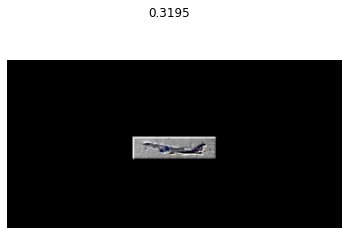

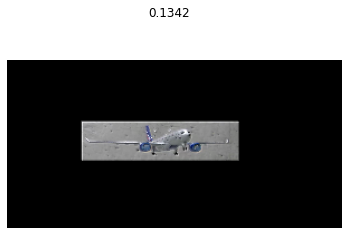

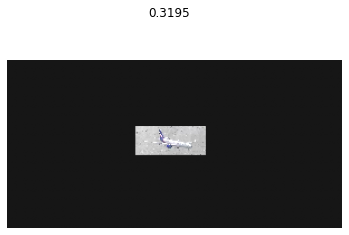

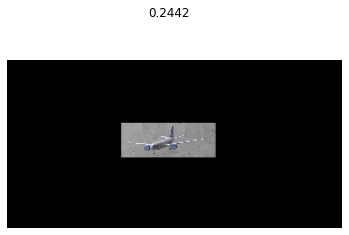

In [218]:
traingen = CustomDataGen(train)

for x, y in traingen:
    break

i = 0
for xx, yy in zip(x, y):
    plt.imshow(xx)
    plt.suptitle(yy)
    plt.axis('off')
    plt.savefig('dist.png')
    plt.show()
    i+=1

## Модель для дистанции

In [222]:
def create_model(input_shape=(150, 300, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, classes=1)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [227]:
K.clear_session()

model = create_model()

metrics = [
    'mape',
]

model.compile(optimizer=Adam(), loss='mse', metrics=metrics)

In [228]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 300, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 10, 1280)       4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 4,377,764
Trainable params: 4,335,741
Non-trainable params: 42,023
______________________________________________

In [229]:
train_df, val_df = train_test_split(train, test_size=0.15)

traingen = CustomDataGen(train_df)
valgen = CustomDataGen(val_df, augment=False)

In [230]:
checkpoint_path = 'models/dist.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [231]:
model.compile(optimizer=Adam(), loss='mse', metrics=metrics)

In [232]:
results = model.fit(traingen, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
253/253 [==============================] - 64s 238ms/step - loss: 0.0280 - mape: 38.9383 - val_loss: 0.0530 - val_mape: 104.5681

Epoch 00001: val_loss improved from inf to 0.05296, saving model to models/dist.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
253/253 [==============================] - 60s 236ms/step - loss: 0.0052 - mape: 17.7051 - val_loss: 0.0409 - val_mape: 39.4234

Epoch 00002: val_loss improved from 0.05296 to 0.04090, saving model to models/dist.h5
Epoch 3/50
253/253 [==============================] - 60s 237ms/step - loss: 0.0029 - mape: 12.9730 - val_loss: 0.0202 - val_mape: 49.7822

Epoch 00003: val_loss improved from 0.04090 to 0.02021, saving model to models/dist.h5
Epoch 4/50
253/253 [==============================] - 60s 239ms/step - loss: 0.0028 - mape: 12.8722 - val_loss: 86648.8594 - val_mape: 82977.6641

Epoch 00004: val_loss did not improve from 0.02021
Epoch 5/50
253/253 [==============================] - 60s 238ms/step - loss: 0.0026 - mape: 11.3423 - val_loss: 1506.3330 - val_mape: 11678.9287

Epoch 00005: val_loss did not improve from 0.02021
Epoch 6/50
253/253 [==============================] - 65s 257ms/step - loss: 0.0024 - mape: 10.9573 - val_loss: 0.3667 - val_mape: 217.9263

Epoch 0000

KeyboardInterrupt: 

In [233]:
val_preds = []
val_gt = []

for x, y in valgen:
    
    preds = model.predict(x)[:, -1]
    
    for xx, yy, p in zip(x, y, preds):
        
        val_preds.append(p)
        val_gt.append(yy)

In [241]:
print('MAE –', 10000*mean_absolute_error(val_gt, val_preds))
print('MAPE –', mean_absolute_percentage_error(val_gt, val_preds))

MAE – 72.61548247120588
MAPE – 0.02608885611167231
